# Instacart Market Basket Analysis

Instacart is a shopping and delivery service that works with stores in your city such as whole foods or Costco or stores that are more local to your city or region.  They will pick up your order and deliver it to your door.  Consequently they have a lot of data on a lot of different shopping behavior that we can use to make predictions about future purchases or suggest items that a person may want to add to their shopping cart based on their past behavior.  Sound familiar?  This is the kind of thing that Amazon has been doing successfully for years.

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import altair as alt
import requests
matplotlib.style.use('ggplot')
sbn.set_style("whitegrid")
import json
import pickle
import scipy
alt.data_transformers.enable('json')


DataTransformerRegistry.enable('json')

## Reading List

* [Market Basket Analysis](http://pbpython.com/market-basket-analysis.html)
* Item Item Recommender Systems


## The Data

This is a BIG data set.  The largest file has over 32 million rows.  
We don't want to start there as that is crazy big.  So we have a smaller file, still
with 1.3 million rows that we can use to start with.

### aisles.csv

     aisle_id,aisle  
     1,prepared soups salads  
     2,specialty cheeses  
     3,energy granola bars  
     ...

### departments.csv

     department_id,department  
     1,frozen  
     2,other  
     3,bakery  
     ...

### order_products__prio.csv

These files specify which products were purchased in each order. `order_products__prior.csv` contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items.  `order_products_train.csv` is much smaller (even though it has 1.3 million records) and is a better place to start.

     order_id,product_id,add_to_cart_order,reordered  
     1,49302,1,1  
     1,11109,2,1  
     1,10246,3,0  
     ... 

### orders.csv

This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

     order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order  
     2539329,1,prior,1,2,08,  
     2398795,1,prior,2,3,07,15.0  
     473747,1,prior,3,3,12,21.0  
     ...
### products.csv

     product_id,product_name,aisle_id,department_id
     1,Chocolate Sandwich Cookies,61,19  
     2,All-Seasons Salt,104,13  
     3,Robust Golden Unsweetened Oolong Tea,94,7  
     ...

## Some exploratory data analysis questions we might do

* How many unique orders do we have?
* what is the most popular first item to add to the cart?  Does that change by day of the week?
* What is the distribution of the number of items in the shopping cart just before checkout?
* what is the most popular second item?
* What department or aisle do users most frequently shop first?
* What department or aisle do users most frequently shop last?
* Create a bar chart of the number of itesm sold by day of the week
* What department gets the most sales?
* Create a chart that shows the number of items bought from each department.
* Do most people shop linearly?  Is there a visualization that would show the path that most people take through the store?  By Aisle? By Department? -- using the order placed in shopping basket.



## Getting down to real market basket analysis

The key question in market basket analysis is what products are most frequently purchased together.

To answer this question we will want to build a table where each row is a product, each column is a product and the cell where two products intersect is the count of the number of times they ended up in the same shopping cart.



In [2]:
mb = pd.DataFrame({'doritos': {'oreos': 2, 'snickers':6}, 'oreos': {'doritos':2, 'snickers':3}, 'snickers': {'doritos': 6, 'oreos':3}})
mb

,doritos,oreos,snickers
doritos,NaN,2.0,6.0
oreos,2.0,NaN,3.0
snickers,6.0,3.0,NaN


Looking at the table it is clear that doritos and snickers are most often purchased together because the total is 6.  The next most common pair is snickers and oreos that just beat out doritos and oreos.

Looking at the table that is not too hard.  We have the shopping cart data so we know what products have ended up in the same cart for thousands of carts.

The challenge is that we have a table with 49,688 columns and 49,688 rows.  That means we have 2,468,897,344 (thats 2+ billion!) cells in our table.  How many of those cells do you think are empty? *Hint* Lots of them!

In [3]:
products = pd.read_csv('ecomm/products.csv')
products.head()

FileNotFoundError: [Errno 2] File b'ecomm/products.csv' does not exist: b'ecomm/products.csv'

The most common operation we are going to want to use with this table is to look up a product id to get more information about the product.  So, lets make the product_id the index of the dataframe to make things faster.

In [7]:
products.set_index('product_id', inplace=True)

In [8]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [9]:
len(products)**2

2468897344

## Constructing an item-item matrix

To construct a matrix of the kind we showed above will take a bit of thought (and time!) So lets do some design first.

1. Its a very good assumption that this data is sparse, so lets start by using a data structure that supports sparsity. -- A dictionary of dictionaries is the key to this. In fact scroll back just a bit and look carefully at how our dataframe was constructed.  You will notice a dictionary like this:

        {'doritos': {'oreos': 2, 'snickers':6}, 
         'oreos': {'doritos':2, 'snickers':3}, 
         'snickers': {'doritos': 6, 'oreos':3}
         }

    If you think about it you will realise that we are storing twice as much data as we need to.  This matrix we are building is symmetric.  the value at i,j will always match the value at j,i because the order of the products is not important.
    
1. The primary source of our data will be the `order_products__train` data.  There the data is sorted by the order number and the order in which products were added to the cart.  We want to take each order as a group and add **all pairs** of items in a cart to the matrix.

1. We can take advantage of the symmetry by ordering the products in the same cart by their product id and always using the lower number as the first index.

Lets make a simple data file that matches our example and see how we can build a sparse version of it.

1 = doritos
2 = oreos
3 = snickers

In [10]:
small_o = pd.read_csv('small_orders.csv')
groups = small_o.groupby('ordernum')
groups.get_group(6)

,ordernum,product
10,6,1
11,6,3


The `get_group` function is awesome!  This allows us to. get a mini data frame containing only the items in one particular order.  Now if we are smart and process the items from smallest to largest we can build our dictionary based matrix no problem.


In [11]:
groups.get_group(1)['product'].sort_values()

0    1
1    2
2    3
Name: product, dtype: int64

In [12]:
cart = groups.get_group(1)['product'].sort_values()
cart.loc[1:]

1    2
2    3
Name: product, dtype: int64

In [13]:
for g in range(1,9):
    cart = groups.get_group(g)['product'].sort_values()
    for i in cart.index:
        for j in cart.loc[i+1:]:
            print(f"products {cart[i]} and {j} in cart")
    print("--")
        
    

products 1 and 2 in cart
products 1 and 3 in cart
products 2 and 3 in cart
--
products 1 and 3 in cart
--
--
products 1 and 3 in cart
--
products 1 and 3 in cart
--
products 1 and 3 in cart
--
products 1 and 2 in cart
products 1 and 3 in cart
products 2 and 3 in cart
--
products 2 and 3 in cart
--


In [14]:
mat = {}
for g in range(1,9):
    cart = groups.get_group(g)['product'].sort_values().tolist()
    for i in range(len(cart)):
        print(mat)
        if cart[i] not in mat:
            mat[cart[i]] = {}
        for j in cart[i+1:]:
            print(cart[i],j)
            mat[cart[i]][j] = mat[cart[i]].get(j,0) + 1
    print("--")
pd.DataFrame(mat)

{}
1 2
1 3
{1: {2: 1, 3: 1}}
2 3
{1: {2: 1, 3: 1}, 2: {3: 1}}
--
{1: {2: 1, 3: 1}, 2: {3: 1}, 3: {}}
1 3
{1: {2: 1, 3: 2}, 2: {3: 1}, 3: {}}
--
{1: {2: 1, 3: 2}, 2: {3: 1}, 3: {}}
--
{1: {2: 1, 3: 2}, 2: {3: 1}, 3: {}}
1 3
{1: {2: 1, 3: 3}, 2: {3: 1}, 3: {}}
--
{1: {2: 1, 3: 3}, 2: {3: 1}, 3: {}}
1 3
{1: {2: 1, 3: 4}, 2: {3: 1}, 3: {}}
--
{1: {2: 1, 3: 4}, 2: {3: 1}, 3: {}}
1 3
{1: {2: 1, 3: 5}, 2: {3: 1}, 3: {}}
--
{1: {2: 1, 3: 5}, 2: {3: 1}, 3: {}}
1 2
1 3
{1: {2: 2, 3: 6}, 2: {3: 1}, 3: {}}
2 3
{1: {2: 2, 3: 6}, 2: {3: 2}, 3: {}}
--
{1: {2: 2, 3: 6}, 2: {3: 2}, 3: {}}
2 3
{1: {2: 2, 3: 6}, 2: {3: 3}, 3: {}}
--


,1,2,3
2,2,NaN,NaN
3,6,3.0,NaN


In [15]:
mat

{1: {2: 2, 3: 6}, 2: {3: 3}, 3: {}}

Ok, now we have a "cooccurence matrix" . given one product we an tell how often that product is in the same shopping cart as many others.  The matrix we have built turns out to be a "lower triangular" matrix because we are only storing the lower left.  The upper right is symmetric so we can save half the storage!

**Important** Saving storage often comes with an additional cost in complexity.  In this case, becuase we are building a "lower triangular" matrix we have to be careful if we want to get all of the products that are purchased together.  We cannot just look at the column corresponding to the product and we cannot just look at the row corresponding to the product.  If we wanted to know everything purchased with product 2 we have to look at the row for 2 as well as the column for two.  The row for 2 tells us that 2 was purchased with 1 (2 times) and the column for 2 tells us that 2 was purchased with 3 (3 times).  If we kept both triangles we could look at either the row or the column.

Let's build the item item matrix for the instacart data and see what we can learn!

The first thing we'll need is a list of unique order ids.  In the toy example above we were able to just use a range of numbers, because we knew that the order numbers started at 1 and went sequentailly.

In [16]:
order_products = pd.read_csv("ecomm/order_products__prior.csv")
order_products.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [17]:
import ipywidgets
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [18]:
%%time

groups = order_products.groupby('order_id')
unique_orderids = order_products.order_id.unique()
mat = {}
for g in log_progress(unique_orderids, size=len(unique_orderids)):
    cart = groups.get_group(g)['product_id'].sort_values().tolist()
    for i in range(len(cart)):
        if cart[i] not in mat:
            mat[cart[i]] = {}
        for j in cart[i+1:]:
            mat[cart[i]][j] = mat[cart[i]].get(j,0) + 1


CPU times: user 39min 39s, sys: 21.5 s, total: 40min
Wall time: 40min 15s


A bit of analysis revealed that there are are HUGE number of entries in the matrix that are a count of 1.  These 1 time "co-purchases" don't give us much useful information for recommending products, so lets save some memory and remove them.

You can't remove things from a dictionary while you are iterating over a dictionary.  So we will need to make a list of keys to remove in one pass and then delete them later.

In [19]:
delkeys = []
for i in mat.keys():
    for k,v in mat[i].items():
        if v == 1:
            delkeys.append((i,k))

len(delkeys)

21944168

Yep, 21.9 million entries in our matrix are 1's

In [21]:
for i,j in delkeys:
    del mat[i][j]

In [22]:
%%time

smat = pd.SparseDataFrame(mat)
smat.head()

CPU times: user 10min 55s, sys: 33.8 s, total: 11min 29s
Wall time: 11min 41s


We can check on the density of our sparse data structure by looking at its density attribute.

In [23]:
smat.density

0.008275774966857377

And we see that it is only 0.8% full!  

We can use idxmax to give us a series that for each column tells us the row with the maximum value for that column.

In [24]:
maxcols = smat.idxmax()
maxcols = maxcols.dropna()

In [25]:
%%time

maxcc = 0
maxrow = None
maxcol = None
for col, row in maxcols.astype(int).iteritems():
    if smat.loc[row, col] > maxcc:
        maxrow = row
        maxcol = col
        maxcc = smat.loc[row,col]


CPU times: user 1.46 s, sys: 1.86 s, total: 3.32 s
Wall time: 5.95 s


In [26]:
maxcc

62341.0

In [27]:
maxrow

47209

In [28]:
maxcol

13176

### Testing our item-item matrix

Let's test the matrix by doing some exploring.  What are the two products most commonly purchased together?



In [29]:
print(f"product {maxrow} was purchased with {maxcol} {maxcc} times")



product 47209 was purchased with 13176 62341.0 times


Because we were smart before and made the product_id the index of the products table we can use this nice lookup syntax to get the product name!

In [30]:
products.loc[maxrow, 'product_name']

'Organic Hass Avocado'

In [31]:
products.loc[maxcol, 'product_name']

'Bag of Organic Bananas'

In [38]:
def get_product_byid(df, idx):
    return df.loc[idx].product_name

OK, so now lets see what our real data has to say about the products that are bought with Doritos.



In [32]:
products[products.product_name.str.contains('Dorito')]

,product_name,aisle_id,department_id
product_id,,,
2144,Doritos,107,19
12540,Doritos Nacho Cheese Sandwich Crackers,78,19
42541,Cheetos Flamin' Hot & Doritos Dinamita Chile L...,107,19


In [33]:
def get_product_count(sp_mat, ix1, ix2):
    if ix1 > ix2:
        return sp_mat.loc[ix1, ix2]
    else:
        return sp_mat.loc[ix2, ix1]

In [34]:
get_product_count(smat, 47209, 13176)

62341.0

In [35]:
def get_all_cocart(sp_mat, pid):
    """
    Return a Pandas series where the index is the product id of products that were in
    the same shopping cart.  The value indicates the count of those times.
    remove the NA's
    """
    return pd.concat((sp_mat[pid], sp_mat.loc[pid])).dropna()

In [36]:
get_all_cocart(smat, 2144).nlargest(10)

24852    68.0
16797    41.0
19734    34.0
16696    25.0
23909    25.0
45064    24.0
28199    23.0
10673    21.0
17122    21.0
13249    17.0
Name: 2144, dtype: float64

In [39]:
for idx, val in get_all_cocart(smat, 2144).nlargest(10).iteritems():
    print(get_product_byid(products,idx), val)


Banana 68.0
Strawberries 41.0
Classic Mix Variety 34.0
Coke Classic 25.0
2% Reduced Fat Milk 25.0
Honey Wheat Bread 24.0
Clementines, Bag 23.0
Original Nooks & Crannies English Muffins 21.0
Honeycrisp Apples 21.0
Skim Milk 17.0


In [40]:
get_product_byid(products, 2144)

'Doritos'

In [41]:
def product_search(df, name):
    prods = df.product_name.str.lower()
    return df[prods.str.contains(name)].product_name


In [42]:
product_search(products, 'diapers')

product_id
15                                Overnight Diapers Size 6
682                   Cruisers Diapers Jumbo Pack - Size 5
765              Swaddlers Diapers Jumbo Pack Size Newborn
879                                Baby Dry Diapers Size 4
1304              Little Movers Comfort Fit Size 3 Diapers
1716     Baby Dry Pampers Baby Dry Diapers Size 5 78 Co...
3087              Baby Dry Pampers Baby Dry Diapers Size 2
3277                 Overnight Diapers Sleepy Sheep Size 4
4630     Baby Dry Pampers Baby Dry Newborn Diapers Size...
5444     Little Snugglers Jumbo Pack Size 2 Disney Diap...
5657                              Baby Dry Diapers  Size 5
5897                               Baby Dry Diapers Size 3
6401               Tender Care Diapers Jumbo Pack - Size 4
6986     Diapers, Overnight, Free & Clear, Size 6 (35+ ...
7487                              Swaddlers Diapers Size 1
7489                   Swaddlers Size 4 Giant Pack Diapers
8102                         Naty Diapers Siz

In [43]:
# snickers - 14261

for idx, val in get_all_cocart(smat, 682).nlargest(10).iteritems():
    print(get_product_byid(products,idx), val)

Strawberries 13.0
Banana 13.0
Zero Rise Orange 7.0
Organic Fuji Apple 7.0
Baby Fresh Pampers Baby Wipes Baby Fresh 1X 64 count  Baby Wipes 6.0
Black Beans 6.0
Honey Nut Cheerios 6.0
Baby Wipes Sensitive 6.0
Select-A-Size Paper Towels, White, 2 Huge Rolls = 5 Regular Rolls  Towels/Napkins 5.0
Peach Yoghurt 5.0


## Cleaning up and saving

Since building the item-item matrix takes some time we should save it in a format that is convenient for us to reload so we don't need to remake it every time.

We can probably reduce the size of our sparse matrix by eliminating all of the cells with a count of 1.  That doesn't really tell us anything that we would want to use in making a recommendation.

We can also eliminate our original dictionary 



In [44]:
smat.to_pickle('item_item.pkl')


### Understanding the item-item matrix

This kind of shopping cart analysis is useful in many areas.  Whether it is news articles, stocks, search terms, or products this kind of recommender is widely used

* Create a histogram that shows the distribution of the shopping cart co-occurence counts.

* How many items in this item-item matrix contain a count of 1.  That is probably not good information and you could save a lot more memory by deleting all of the items with a count of 1 from smat.

* Can you make a visualization of this item-item matrix?

In [45]:
forhist = pd.DataFrame({'allvals': smat.values.flatten()})


In [46]:
forhist = forhist.dropna()


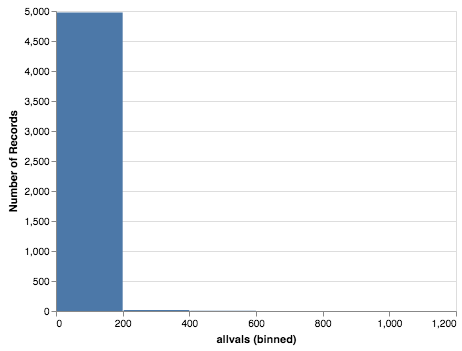

In [47]:
alt.Chart(forhist).mark_bar().encode(x=alt.X('allvals', bin=True),y='count()')

### Experimenting with item-item recommendations

* The histogram above shows that the vast majority of the items are in the 0-200 co-occurence range.  But the items purchased together outside that big bar are interesting.  Write a function to print out the item pairs that have been in the same shopping cart more than 200 times.

* Re-do the histogram so that it focuses in on the products that have between 0 and 200 co-occurrences.  

* Write a function called top_n that takes a product name to search for, allows the user to select the best match and then returns the topn recommendatons for products that have been purchased with the selected item.

* Write a function that takes a product id as its parameter and then recommends the top10 products to go with the given product but from the same department or same aisle.

* One of the problems with a recommender like this one is that it tends to recommend a lot of popular items.  We might call this the bananna problem in this dataset!  Can you devise a strategy to recommend things that are not just the popular things?

* Design an experiment whereby you can train an item-item model like we have done above and then test it.  Perhaps in the training set you withold that last item added to the shopping cart to see how frequently you can predict the last item based on the first items.

* Challenge - The original collaborative filtering recommender system was not item-item like this was.  It was user-user where the recommendations came from finding a group of users similar to the subject user based on their ratings or purchase behavior.  The system would then recommend items to the subject user based on items that their similar users had purchased but the subject had not.  Can you write such a recommender and devise an experiment to compare it to the item-item recommender?


## Visualizing Grocery Data

* How can we show top combinations of two things?

* Visualize the flow from department to department or from aisle to aisle.

* You can get some inspiration from https://python-graph-gallery.com/


To accomplish this you will have to dig into some new packages that we have not used in class.  But this is all part of the process.



We need to create square adjacency matrix -- Aisle to Aisle.  We'll use this to build our chord diagram and other graph like visualizations.

0. Merge the order_product data frame with the aisle data frame so we have the aisle number for each product. (we can drop the aisle name to save memory)
1. Iterate over each order
2. Order the order by add_to_cart_order
3. Increase the count in from aisle (row) to to aisle (column) - this is a directed graph.







In [16]:
aisle_mat = pd.DataFrame(0, index=range(1,135),columns=range(1,135))

In [17]:
flowdf = op.merge(products, on='product_id').merge(adf, on='aisle_id')


In [18]:
%%time

tco = flowdf.groupby('order_id')
for order in tco.groups.keys():
    contents = tco.get_group(order).sort_values('add_to_cart_order')
    rowit = contents.iterrows()
    start_aisle = next(rowit)[1]['aisle_id']
    for ix, row in rowit:
        #print(start_aisle, row['aisle_id'])
        try:
            aisle_mat.loc[start_aisle][row['aisle_id']] += 1
        except:
            print("bad index", start_aisle, row['aisle_id'], type(start_aisle), type(row['aisle_id']))
        start_aisle = row['aisle_id']
        

    

CPU times: user 3h 4min 26s, sys: 2min 7s, total: 3h 6min 34s
Wall time: 3h 11min 18s


In [20]:
aisle_mat.to_csv('aisle_mat.csv')

In [ ]:
for ix, row in contents.iterrows():
    print(row['product_id'], row['aisle_id'])

In [ ]:
x = contents.iterrows()
next(x)[1]['aisle_id']

In [ ]:
for i, j in x:
    print(j['product_id'])

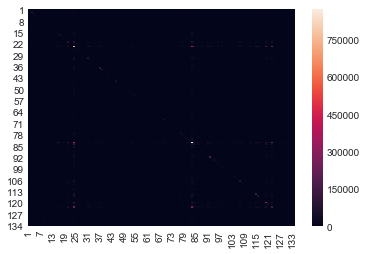

In [21]:
sbn.heatmap(aisle_mat)

Looks like a lot of small values!   Lets make a histogram of the whole thing and see.


In [22]:
#plt.hist(aisle_mat.values.flatten(),bins=100)

In [114]:
for i in range(1,135):
    aisle_mat.loc[i][i] = 0

In [116]:
x = aisle_mat.values.flatten()


In [117]:
sall = aisle_mat.values.sum()

In [118]:
y = aisle_mat.applymap(lambda x: x/sall)

In [119]:
z = y.applymap(lambda x: x if x > 0.001 else np.nan)

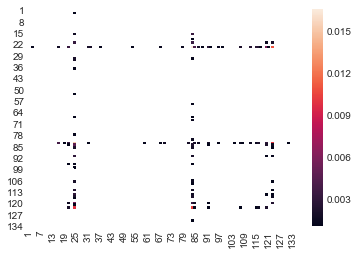

In [120]:
sbn.heatmap(z)

In [13]:
aisle_mat = pd.read_csv('aisle_mat.csv',index_col='aid')

In [14]:
aisle_mat.head()

,1,2,3,4,5,6,7,8,9,10,...,125,126,127,128,129,130,131,132,133,134
aid,,,,,,,,,,,,,,,,,,,,,
1,5151,177,621,362,83,74,56,152,336,8,...,54,20,30,401,388,205,344,8,19,12
2,216,2692,464,387,168,62,152,88,882,20,...,34,30,52,602,322,218,933,8,21,19
3,632,417,126287,1871,311,322,247,380,1455,47,...,1152,128,299,1509,1849,2106,1800,48,158,33
4,356,405,1844,20762,717,192,186,165,2519,49,...,255,122,268,1234,2176,1176,3130,32,110,27
5,90,169,266,681,2325,57,110,47,673,44,...,31,42,104,639,539,245,744,5,27,8


In [15]:
aisle_mat['total'] = aisle_mat.apply(lambda x : x.sum(), axis=1)

In [16]:
aisle_mat.sort_values('total', ascending=False, inplace=True)
aisle_mat.head()
    


,1,2,3,4,5,6,7,8,9,10,...,126,127,128,129,130,131,132,133,134,total
aid,,,,,,,,,,,,,,,,,,,,,
24,6545,6616,33754,12545,3020,2600,2829,2646,13162,443,...,709,1248,16043,13076,13474,16945,228,910,372,3324654
83,4473,8381,17158,11751,6362,2133,3818,1698,20901,615,...,693,981,17890,12322,10233,25437,219,676,294,3143603
123,4134,4197,13228,6850,2397,1204,1747,1198,9405,292,...,454,764,8630,7515,6414,11072,173,461,163,1600584
120,2354,2498,16219,5950,1080,1072,801,937,5231,99,...,306,668,5669,5561,5921,6478,106,307,78,1354392
21,1760,6626,8445,6728,2257,640,1038,700,10388,268,...,296,659,9307,6071,3891,10790,100,312,153,888985


In [20]:
row_order = aisle_mat.index
row_order = row_order.tolist()
aisle_mat.index

Int64Index([ 24,  83, 123, 120,  21,  84, 115, 107,  91, 112,
            ...
            118, 134,  55, 109,  10,  44, 102,  82, 132, 113],
           dtype='int64', name='aid', length=134)

In [25]:
aisle_map = pd.merge(aisle_mat, adf, left_index=True, right_on='aisle_id')['aisle']
aisle_map.values.tolist()[:10]

['fresh fruits',
 'fresh vegetables',
 'packaged vegetables fruits',
 'yogurt',
 'packaged cheese',
 'milk',
 'water seltzer sparkling water',
 'chips pretzels',
 'soy lactosefree',
 'bread']

In [40]:
am = aisle_mat.values.tolist()[:20][:20]
for i in range(len(am)):
    am[i][i] = 0.0

In [47]:
pickle.dump(am,file=open('am.pkl', 'wb'))

In [48]:
import pprint

In [26]:
depts = pd.read_csv('ecomm/departments.csv')
depts

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk
